In [1]:
#modelos
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#Manipulação dos dados
import pandas as pd

#Gráficos 
import matplotlib.pyplot as plt
import seaborn as sns

#Calculos matemáticos
import numpy as np

#Pre processamento dos dados
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Mátricas de avaliação
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, classification_report

#Avaliação do modelo
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,cross_val_score

#Auxilia na avaliação do modelo
from scipy.stats import uniform, randint


#Separação dos dados em treino e teste
from sklearn.model_selection import train_test_split

#importação dos modulos
import sys
import os
sys.path.append(os.path.abspath('../')) 

#Uteis
from Utils.Uteis import Graficos, AvalicaoModelo, Modelo


In [2]:
utilAvaliacaoModelos = AvalicaoModelo()
utilGraficos = Graficos()
utilModeloSC = Modelo()

In [3]:
df = pd.read_csv("../Dados/Base de dados empréstimo tratada.csv")
df.head()

,Unnamed: 0,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,0,0,445412.0,Short Term,709.0,1167493.0,8.0,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0
1,1,0,262328.0,Short Term,716.0,1167759.0,10.0,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0.0,229976.0,850784.0,0.0,0.0
2,3,0,347666.0,Long Term,721.0,806949.0,3.0,Own Home,Debt Consolidation,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0
3,4,0,176220.0,Short Term,716.0,1167759.0,5.0,Rent,Debt Consolidation,20639.70,6.1,15.0,0.0,253460.0,427174.0,0.0,0.0
4,5,1,206602.0,Short Term,7290.0,896857.0,10.0,Home Mortgage,Debt Consolidation,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0


### Etapas para Criação dos Modelos

1. **Transformação de Colunas Categóricas**

   * Converter as colunas categóricas em valores numéricos.
   * Utilizar as técnicas **OneHotEncoder** e **LabelEncoder** para esse processo.

2. **Divisão da Base de Dados**

   * Separar os dados em dois conjuntos: treino e teste.
   * Garantir a representatividade de ambos os conjuntos para um treinamento eficaz.

3. **Ajuste das Colunas Numéricas**

   * Para modelos lineares: aplicar transformação logarítmica às colunas numéricas, melhorando a adequação dos dados à distribuição requerida.
   * Para modelos baseados em árvores: manter os dados na forma original, considerando que esses modelos não são impactados pela distribuição dos dados.

Essas etapas preparam a base de dados para o treinamento dos modelos, garantindo um processo eficiente e alinhado às características específicas de cada abordagem.


In [4]:
# Label Encoding para 'Term'
labelEncoder = LabelEncoder()
df["TermLabel"] = labelEncoder.fit_transform(df["Term"])

# OneHot Encoding para 'Home Ownership' e 'Purpose'
# Usando o mesmo encoder para ambas as colunas (mas pode ser melhor usar encoders separados)
oneHotEncoder = OneHotEncoder(sparse_output=False)  # sparse_output=False para obter array denso

# Home Ownership
homeOneHot = oneHotEncoder.fit_transform(df[["Home Ownership"]])
homeOneHotDf = pd.DataFrame(homeOneHot, 
                          columns=oneHotEncoder.get_feature_names_out(["Home Ownership"]))

# Purpose (precisa fit_transform novamente ou usar encoder separado)
purposeOneHot = oneHotEncoder.fit_transform(df[["Purpose"]])
purposeOneHotDf = pd.DataFrame(purposeOneHot, 
                             columns=oneHotEncoder.get_feature_names_out(["Purpose"]))

# Concatenar tudo
df = pd.concat([df, homeOneHotDf, purposeOneHotDf], axis=1)

df.drop(["Home Ownership", "Term", "Purpose", "Unnamed: 0"], axis = 1, inplace=True)
df.head()

,Loan Status,Current Loan Amount,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,...,Purpose_Medical Bills,Purpose_Other,Purpose_Take a Trip,Purpose_major_purchase,Purpose_moving,Purpose_other,Purpose_renewable_energy,Purpose_small_business,Purpose_vacation,Purpose_wedding
0,0,445412.0,709.0,1167493.0,8.0,5214.74,17.2,6.0,1.0,228190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,262328.0,716.0,1167759.0,10.0,33295.98,21.1,35.0,0.0,229976.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,347666.0,721.0,806949.0,3.0,8741.90,12.0,9.0,0.0,256329.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,176220.0,716.0,1167759.0,5.0,20639.70,6.1,15.0,0.0,253460.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,206602.0,7290.0,896857.0,10.0,16367.74,17.3,6.0,0.0,215308.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88516 entries, 0 to 88515
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan Status                   88516 non-null  int64  
 1   Current Loan Amount           88516 non-null  float64
 2   Credit Score                  88516 non-null  float64
 3   Annual Income                 88516 non-null  float64
 4   Years in current job          88516 non-null  float64
 5   Monthly Debt                  88516 non-null  float64
 6   Years of Credit History       88516 non-null  float64
 7   Number of Open Accounts       88516 non-null  float64
 8   Number of Credit Problems     88516 non-null  float64
 9   Current Credit Balance        88516 non-null  float64
 10  Maximum Open Credit           88516 non-null  float64
 11  Bankruptcies                  88516 non-null  float64
 12  Tax Liens                     88516 non-null  float64
 13  T

Analisar a distribuição da target(Loan Status) para saber se está muito desbalanceada

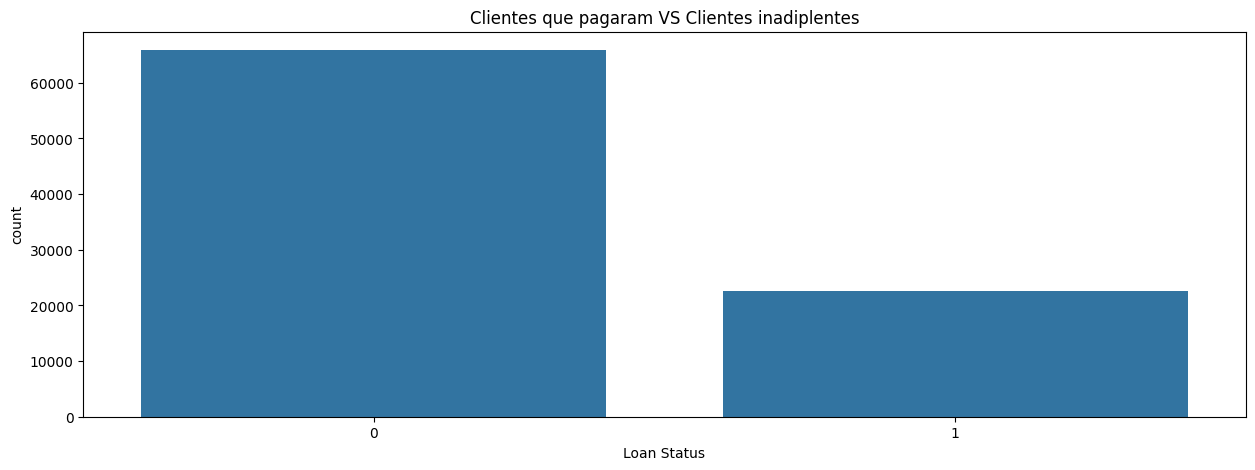

In [20]:
clientesPagaramEInadiplentes = df["Loan Status"].value_counts().reset_index()
plt.figure(figsize=[15, 5])
plt.title("Clientes que pagaram VS Clientes inadiplentes")
sns.barplot(data=clientesPagaramEInadiplentes, x= "Loan Status", y = "count", )
plt.show()

Como a classe apresenta um desbalanceamento significativo entre clientes que pagam (classe 0) e clientes que não pagam (classe 1), a acurácia não é a métrica mais adequada para avaliar o desempenho do modelo. Isso ocorre porque, em cenários de desbalanceamento, o modelo pode facilmente atingir uma alta acurácia apenas aprendendo a prever a classe majoritária (neste caso, os clientes que pagam, classe 0).

Por exemplo, se 90% dos clientes pertencem à classe 0, um modelo que prevê todos os casos como classe 0 alcançará 90% de acurácia, mas será completamente inútil para identificar clientes inadimplentes (classe 1). Isso é problemático, pois, nesse contexto, o objetivo principal é justamente identificar os casos de inadimplência para mitigar os riscos associados.

Além disso, a tendência de o modelo "aprender" a prever quase sempre a classe majoritária pode levar a erros graves ao classificar exemplos da classe minoritária, o que compromete diretamente sua utilidade prática. Dessa forma, o modelo deve ser ajustado para dar mais atenção à classe 1, utilizando abordagens que valorizem a identificação correta dessa classe.

Para isso, métricas como precisão, recall e F1-score, que levam em consideração a performance individual em cada classe, são mais adequadas. O recall da classe 1, em especial, é crucial, pois mede a proporção de inadimplentes identificados corretamente pelo modelo. Além disso, técnicas como reamostragem (oversampling ou undersampling), ajuste de pesos nas classes ou uso de algoritmos projetados para lidar com desbalanceamento podem ajudar a melhorar o desempenho do modelo na detecção da classe minoritária.


In [8]:
X = df.drop(["Loan Status"], axis=1) 

y = df["Loan Status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Avaliação dos modelos

Modelos baseados em arvóres de decisão

In [7]:

utilAvaliacaoModelos.predicaoModelosArvores(DecisionTreeClassifier, X_train, y_train)
utilAvaliacaoModelos.predicaoModelosArvores(RandomForestClassifier, X_train, y_train)
utilAvaliacaoModelos.predicaoModelosArvores(BalancedRandomForestClassifier, X_train, y_train)


Modelo  <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Acurácia: 0.7914
Recall: 0.6168
F1-Score: 0.6019
Precision: 0.5877
Modelo  <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Acurácia: 0.8370
Recall: 0.5108
F1-Score: 0.6157
Precision: 0.7750
Modelo  <class 'imblearn.ensemble._forest.BalancedRandomForestClassifier'>
Acurácia: 0.3210
Recall: 0.9986
F1-Score: 0.4293
Precision: 0.2734


Modelo lineares

In [8]:
utilAvaliacaoModelos.predicaoModelosLogistico(LogisticRegression, X_train, y_train)

Modelo  <class 'sklearn.linear_model._logistic.LogisticRegression'>
Acurácia: 0.8171
Recall: 0.5193
F1-Score: 0.5922
Precision: 0.6888
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     10541
           1       0.69      0.52      0.59      3622

    accuracy                           0.82     14163
   macro avg       0.77      0.72      0.74     14163
weighted avg       0.81      0.82      0.81     14163



Modelos mais robustos

In [9]:
utilAvaliacaoModelos.predicaoModeloRobustos(XGBClassifier, X_train, y_train)
utilAvaliacaoModelos.predicaoModeloRobustos(LGBMClassifier, X_train, y_train)

Modelo  <class 'xgboost.sklearn.XGBClassifier'>
Acurácia: 0.8103
Recall: 0.6151
F1-Score: 0.6238
Precision: 0.6328
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     10541
           1       0.63      0.62      0.62      3622

    accuracy                           0.81     14163
   macro avg       0.75      0.75      0.75     14163
weighted avg       0.81      0.81      0.81     14163

Modelo  <class 'lightgbm.sklearn.LGBMClassifier'>
Acurácia: 0.8095
Recall: 0.6126
F1-Score: 0.6219
Precision: 0.6315
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     10541
           1       0.63      0.61      0.62      3622

    accuracy                           0.81     14163
   macro avg       0.75      0.74      0.75     14163
weighted avg       0.81      0.81      0.81     14163



Analisando todos os modelos acima, os que apresentaram os melhores desempenhos foram o XGBoost e o LightGBM. Portanto, criarei uma função para testar os hiperparâmetros desses dois modelos e verificar qual deles se sai melhor. Utilizarei o RandomizedSearchCV, pois o GridSearchCV possui um custo computacional muito elevado.

In [6]:
def busca_aleatoria_modelo(modelo, parametros, X_train, y_train, n_iter=50, scoring='recall', cv_folds=5, n_jobs=-1, random_state=42):

    # Configura a validação cruzada estratificada
    cv = StratifiedKFold(cv_folds, shuffle=True, random_state=random_state)
    
    # Configura a busca aleatória
    random_search = RandomizedSearchCV(
        estimator=modelo,
        param_distributions=parametros,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=1,
        n_jobs=n_jobs,
        random_state=random_state
    )
    
    # Realiza a busca
    random_search.fit(X_train, y_train)
    
    # Converte os resultados para DataFrame e ordena pelo score
    resultados = pd.DataFrame(random_search.cv_results_)
    resultadosOrdenados = resultados.sort_values(by="mean_test_score", ascending=False)
    
    return resultadosOrdenados, random_search.best_estimator_

In [23]:
parametrosXGB = {
    'max_depth': randint(3, 5),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [2.909793636551867],  # Ajuste para desbalanceamento
}
    

dfXGB, melhorEstimadorXGB = busca_aleatoria_modelo(XGBClassifier(), parametrosXGB, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [24]:
dfXGB.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,1.936679,0.246519,0.054490,0.007607,0.939566,0.226519,3,7,2.909794,0.616173,"{'colsample_bytree': 0.9395655297064336, 'lear...",0.635837,0.651670,0.645224,0.629210,0.624517,0.637291,0.010003,1
18,1.957522,0.075112,0.071274,0.017971,0.965984,0.265012,4,2,2.909794,0.638164,"{'colsample_bytree': 0.9659838702175123, 'lear...",0.643015,0.640077,0.644671,0.620652,0.628658,0.635415,0.009261,2
14,1.767101,0.096295,0.053032,0.003481,0.986102,0.192110,3,9,2.909794,0.718509,"{'colsample_bytree': 0.9861021229056552, 'lear...",0.639150,0.645598,0.642463,0.623965,0.621480,0.634531,0.009886,3
49,1.288711,0.057675,0.022235,0.002600,0.689708,0.223654,3,5,2.909794,0.671529,"{'colsample_bytree': 0.689707723784224, 'learn...",0.633076,0.646702,0.638321,0.627830,0.626726,0.634531,0.007354,4
0,1.824855,0.039511,0.066832,0.011952,0.749816,0.295214,3,8,2.909794,0.839463,"{'colsample_bytree': 0.749816047538945, 'learn...",0.642463,0.641457,0.641911,0.622308,0.623965,0.634421,0.009234,5


In [51]:
parametrosLGBM = {
    'num_leaves': randint(20, 100),  # Substitui max_depth no LGBM
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [2.909793636551867],  # Mesmo ajuste para desbalanceamento
    'reg_alpha': uniform(0, 1),  # L1 regularization (novo)
    'reg_lambda': uniform(0, 1),  # L2 regularization (novo)
    'n_estimators': randint(100, 500)  # Número de árvores (adicionado)
}

dfLGBM, melhorEstimadorLGBM = busca_aleatoria_modelo(LGBMClassifier(), parametrosLGBM, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [52]:
dfLGBM.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_weight,param_n_estimators,param_num_leaves,param_reg_alpha,...,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,2.196438,0.118596,0.035258,0.005756,0.703177,0.207995,9,159,21,0.996254,...,0.823317,"{'colsample_bytree': 0.7031766510860622, 'lear...",0.622308,0.638697,0.628106,0.612093,0.609608,0.622162,0.010656,1
21,4.994583,0.496784,0.056243,0.006943,0.837079,0.034256,8,222,36,0.728216,...,0.852922,"{'colsample_bytree': 0.8370786895517575, 'lear...",0.620652,0.630141,0.623136,0.607951,0.611541,0.618684,0.008015,2
9,2.882505,0.247933,0.035755,0.003316,0.757953,0.098046,3,180,27,0.729007,...,0.629618,"{'colsample_bytree': 0.7579526072702278, 'lear...",0.621756,0.626829,0.628934,0.606019,0.603258,0.617359,0.010681,3
13,2.184261,0.263082,0.029649,0.006429,0.680688,0.278729,1,151,23,0.907566,...,0.764153,"{'colsample_bytree': 0.6806876809341584, 'lear...",0.619823,0.622964,0.624241,0.609884,0.608227,0.617028,0.006687,4
6,2.172799,0.197658,0.034968,0.001236,0.902145,0.137547,6,205,23,0.184854,...,0.910053,"{'colsample_bytree': 0.902144564127061, 'learn...",0.617615,0.620204,0.620375,0.610160,0.604914,0.614654,0.006121,5


Após a análise dos resultados, identifiquei que o modelo com melhor desempenho foi o XGBoost Classifier, um algoritmo baseado em árvores de decisão que utiliza o método de gradiente boosting para melhorar sua precisão iterativamente.

Agora, irei realizar uma validação cruzada, técnica que divide os dados em subconjuntos (ou folds) para treinar e testar o modelo de forma repetida. Isso permite avaliar o desempenho do modelo em diferentes cenários, garantindo maior robustez na análise e reduzindo o risco de overfitting.

Em seguida, analisarei a Curva ROC (Receiver Operating Characteristic), que é uma ferramenta para avaliar a capacidade do modelo em discriminar entre classes, observando a relação entre a taxa de verdadeiros positivos (TPR) e a taxa de falsos positivos (FPR).

Por fim, verificarei a Matriz de Confusão, que detalha os erros e acertos do modelo, mostrando o número de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos. Essa análise ajudará a entender como o modelo está se comportando em relação a cada classe e permitirá ajustes, se necessário.

In [25]:
estimadorFinal = melhorEstimadorXGB
cv = StratifiedKFold(5, shuffle=True, random_state=42)
scoresAccuracy = cross_val_score(estimadorFinal, X_train, y_train, cv=cv, scoring='accuracy')
scoresRecall = cross_val_score(estimadorFinal, X_train, y_train, cv=cv, scoring='recall')

# Resultados
print(f"Acurácia em cada fold: Acuracia =  {scoresAccuracy}")
print(f"Acurácia em cada fold: recall =  {scoresRecall}")
      
print("Acurácia média:", scoresAccuracy.mean())
print("Recall medio: ", scoresRecall.mean())

Acurácia em cada fold: Acuracia =  [0.7971475  0.79912448 0.80066375 0.79275526 0.79409688]
Acurácia em cada fold: recall =  [0.63583655 0.63952526 0.64356709 0.6228603  0.62810602]
Acurácia média: 0.7967575727725423
Recall medio:  0.6339790433321196


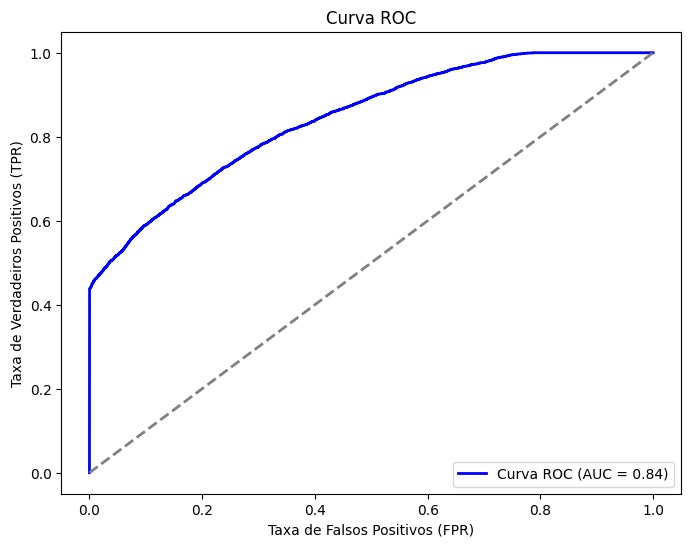

In [26]:
utilGraficos.curvaRoc(estimadorFinal, X_test, y_test) #Retorna o gráfico da curva ROC

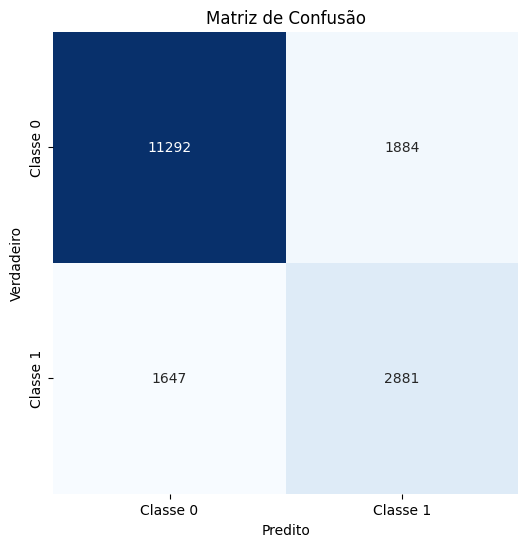

In [27]:
utilGraficos.matrizConfusao(estimadorFinal, X_test, y_test)#Retorna a Matriz de confusão

O desempenho do modelo **XGBoost Classifier** foi avaliado em uma base de dados desbalanceada, com uma **Curva ROC** de 0.84 e a matriz de confusão apresentada.

A **Curva ROC** de 0.84 indica que o modelo apresenta uma boa capacidade de distinguir entre as classes, mesmo em um cenário de dados desbalanceados. Esse valor reflete a consistência do modelo em manter um equilíbrio entre a taxa de verdadeiros positivos e falsos positivos.

### Análise da Matriz de Confusão:

* **Classe 0 (Clientes que pagam):**

  * 11.292 casos corretamente classificados como Classe 0 (Verdadeiros Negativos).
  * 1.884 casos incorretamente classificados como Classe 1 (Falsos Positivos).

* **Classe 1 (Clientes que não pagam):**

  * 2.881 casos corretamente classificados como Classe 1 (Verdadeiros Positivos).
  * 1.647 casos incorretamente classificados como Classe 0 (Falsos Negativos).

A matriz de confusão revela que o modelo identifica bem a classe majoritária (Classe 0), mas apresenta limitações ao prever a classe minoritária (Classe 1), o que é esperado devido à baixa representatividade dessa classe nos dados. Esse comportamento é típico em cenários onde poucas variáveis possuem alta correlação com a variável alvo, dificultando uma separação mais precisa entre as classes.

### Conclusão:

Apesar da dificuldade em classificar a classe minoritária, o modelo demonstra um desempenho consistente, com uma **Curva ROC** sólida e avanços na identificação de clientes da Classe 1. Essa melhoria é relevante, já que clientes da Classe 1 (inadimplentes) representam o maior risco para a empresa. Ajustes futuros no modelo, como o aumento de penalidades para a classe minoritária, podem continuar aprimorando o recall, alinhando melhor o modelo ao objetivo do negócio.



In [28]:
utilAvaliacaoModelos.avaliacaoFinalDoModelo(estimadorFinal, X_test, y_test)

Acurácia: 0.8006
Recall: 0.6363
F1-Score: 0.6200
Precision: 0.6046
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     13176
           1       0.60      0.64      0.62      4528

    accuracy                           0.80     17704
   macro avg       0.74      0.75      0.74     17704
weighted avg       0.80      0.80      0.80     17704



Os resultados do teste final do modelo **XGBoost Classifier** indicam que, apesar dos desafios de trabalhar com uma base desbalanceada, o modelo apresenta consistência para prever se o cliente irá pagar ou não.

### Principais métricas:

* **Acurácia:** 80%
* **Recall:** 63.63%
* **F1-Score:** 62%
* **Precision:** 60%

#### Desempenho por classe:

* Para a **classe 0** (clientes que pagam), o modelo obteve uma alta precisão e recall, resultando em um **F1-Score de 0.86**.
* Para a **classe 1** (clientes que não pagam), o modelo enfrentou desafios devido ao desbalanceamento, mas apresentou um **recall de 63%**, indicando que consegue capturar uma boa parte dos clientes inadimplentes.

### Conclusão:

Embora o desbalanceamento e a limitada relação das features com a variável alvo tenham dificultado a separação precisa entre as classes, o modelo demonstrou ser robusto e confiável para auxiliar na previsão de inadimplência. Contudo, reconhecendo que a **classe 1** representa maior risco e prejuízo financeiro para a empresa, serão adicionadas melhorias no modelo para aumentar a precisão na identificação de clientes inadimplentes, minimizando falsos negativos e, consequentemente, os prejuízos associados.



In [9]:
parametrosXGB = {
    'max_depth': randint(3, 5),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'scale_pos_weight': [3.4],  # Ajuste para desbalanceamento
}
    

dfXGB, melhorEstimadorXGB = busca_aleatoria_modelo(XGBClassifier(), parametrosXGB, X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [10]:
estimadorFinalAjustado = melhorEstimadorXGB
utilAvaliacaoModelos.avaliacaoFinalDoModelo(estimadorFinalAjustado, X_test, y_test)

Acurácia: 0.7685
Recall: 0.7047
F1-Score: 0.6090
Precision: 0.5361
              precision    recall  f1-score   support

           0       0.89      0.79      0.84     13176
           1       0.54      0.70      0.61      4528

    accuracy                           0.77     17704
   macro avg       0.71      0.75      0.72     17704
weighted avg       0.80      0.77      0.78     17704



Os resultados do novo ajuste no modelo **XGBoost Classifier**, utilizando um valor maior para o parâmetro `scale_pos_weight`, indicam que, apesar de um trade-off esperado nas métricas de **precision** e **acurácia**, o desempenho na identificação da classe 1 (clientes que não pagam) melhorou significativamente, alinhando-se melhor ao objetivo principal do modelo.

### Principais métricas:

* **Acurácia:** 77%
* **Recall:** 70.5%
* **F1-Score:** 60.9%
* **Precision:** 53.61%

#### Desempenho por classe:

* Para a **classe 0** (clientes que pagam), o modelo manteve um desempenho consistente, com um **F1-Score de 0.84**, mesmo apresentando uma pequena redução na precisão.
* Para a **classe 1** (clientes que não pagam), o **recall aumentou para 70%**, superando o desempenho anterior e indicando que o modelo agora captura uma proporção maior de clientes inadimplentes. O **F1-Score** da classe também melhorou, consolidando o progresso.

### Conclusão:

Apesar de uma redução na **precision** (resultando em mais falsos positivos), o modelo agora é mais eficaz na identificação de clientes inadimplentes, que são a prioridade, pois representam o maior impacto financeiro para a empresa. Este ajuste permitiu alcançar o objetivo de focar na classe 1, mesmo que isso tenha gerado um leve aumento de falsos positivos. Em cenários como este, onde o custo de um falso negativo é maior que o de um falso positivo, o modelo atualizado cumpre melhor o papel de mitigar os prejuízos causados por inadimplências.

O resultado final demonstra que o ajuste no parâmetro foi um passo estratégico para atingir os objetivos do negócio, priorizando o recall da classe 1 sem comprometer drasticamente o desempenho geral do modelo. Agora, para finalizar, irei analisar novamente a **Curva ROC** e a **matriz de confusão** para avaliar como essas mudanças impactaram esses aspectos, além de verificar as colunas que estão tendo maior influência na decisão do modelo.


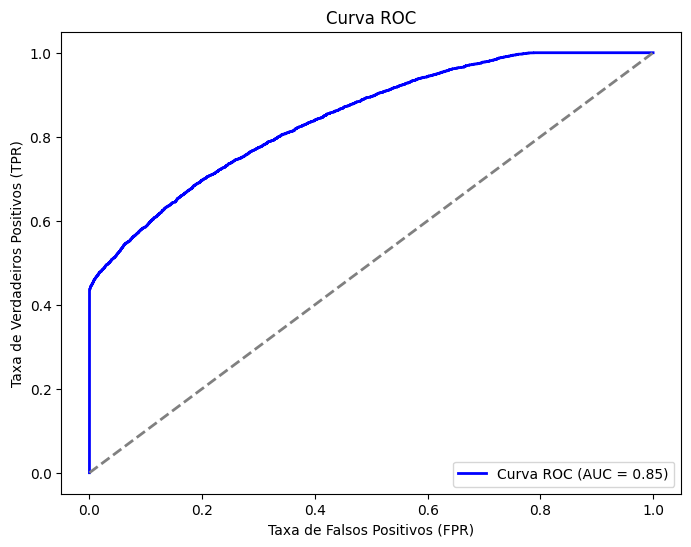

In [31]:
utilGraficos.curvaRoc(estimadorFinalAjustado, X_test, y_test) #Retorna o gráfico da curva ROC

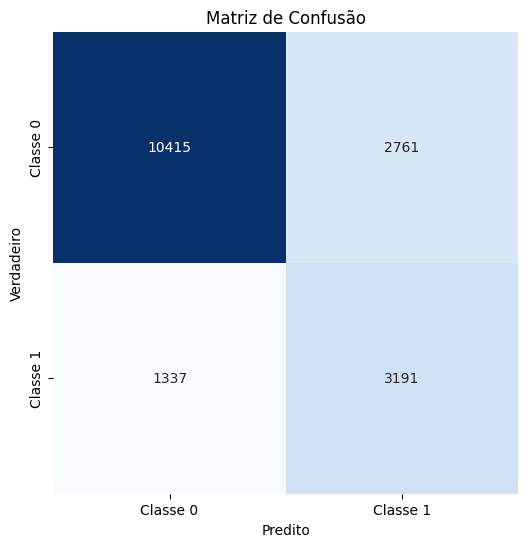

In [32]:
utilGraficos.matrizConfusao(estimadorFinalAjustado, X_test, y_test)

### Análise da Curva ROC e da Matriz de Confusão

Após os ajustes realizados no modelo **XGBoost Classifier**, a **Curva ROC** apresentou uma melhoria, alcançando um valor de **0.85**, o que reflete um aumento na capacidade do modelo de discriminar entre as classes 0 e 1, reforçando a eficácia do ajuste.

#### Análise da Matriz de Confusão:

* **Classe 0 (Clientes que pagam):**

  * **Verdadeiros positivos:** 10.415
  * **Falsos negativos:** 1.337
  * O modelo continua com um bom desempenho em identificar corretamente os clientes que irão pagar, mantendo uma taxa de erros (falsos negativos) relativamente baixa.

* **Classe 1 (Clientes que não pagam):**

  * **Verdadeiros positivos:** 3.191
  * **Falsos positivos:** 2.761
  * Houve uma melhora significativa na identificação de clientes inadimplentes (classe 1), com o modelo capturando um número maior de verdadeiros positivos. O aumento de falsos positivos foi um custo esperado, porém necessário para priorizar a identificação dessa classe crítica.

Esses resultados reforçam que o modelo agora está mais alinhado com o objetivo principal, que é prever clientes inadimplentes com maior precisão e recall. Além disso, a melhoria na **Curva ROC** e a análise da matriz evidenciam que o ajuste de parâmetro foi eficaz para atingir esse equilíbrio, especialmente em contextos onde os custos de falsos negativos são altos.


Text(0.5, 1.0, 'Importância das Variáveis no Modelo (Cores por Influência)')

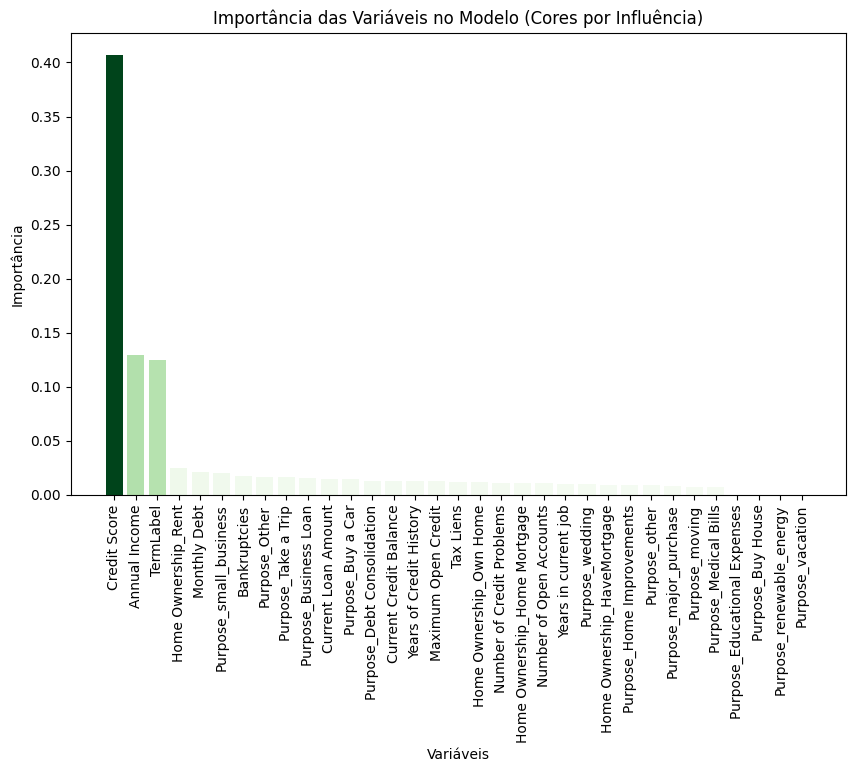

In [ ]:
utilGraficos.importanciaVariaveis(X_train, estimadorFinalAjustado)

### Conclusão Final

Os ajustes realizados no modelo **XGBoost Classifier** resultaram em melhorias significativas em sua capacidade preditiva, com a **Curva ROC** alcançando um valor de **0,85**, evidenciando um desempenho mais robusto na discriminação entre clientes que pagam (classe 0) e aqueles que não pagam (classe 1). A análise da matriz de confusão confirmou que o modelo está mais eficaz na identificação de clientes inadimplentes, ainda que com um aumento esperado de falsos positivos.

Em relação à importância das variáveis, a análise destacou a coluna **Credit Score** como o fator mais influente no desempenho do modelo, sendo a principal variável decisiva. As colunas **Term** e **Current Loan Amount** também apresentaram contribuições relevantes, embora em menor proporção. Por outro lado, as demais variáveis demonstraram impacto mínimo ou nulo no processo decisório, indicando sua menor relevância no contexto deste problema.

Com essas melhorias e análises, o modelo está mais preparado para auxiliar na identificação de clientes inadimplentes, contribuindo para a mitigação de prejuízos financeiros. Esses resultados também apontam para oportunidades de otimizações futuras, como a exploração de novas variáveis ou ajustes adicionais, visando um aprimoramento contínuo. O modelo será salvo para implementação em produção.


In [11]:

utilModeloSC.salvarModelo(estimadorFinalAjustado, '../Modelo/modelo.joblib')



Modelo salvo em: ../Modelo/modelo.joblib


In [12]:
utilModeloSC.carregarModelo("../Modelo/modelo.joblib")

Modelo carregado de: ../Modelo/modelo.joblib


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.9395655297064336), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.22651885634946198), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)